In [12]:
import torch
torch.__version__
torch.cuda.is_available()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
def read_new_email(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    parts = text.split('"')  
    
    subject = parts[1].strip()
    body = parts[3].strip()
    label = parts[5].strip()
    
    new_email = {'Subject':subject, 'Body':body, 'Label':label}
    return new_email

In [14]:
confirmation_emails = []

for i in range(1, 251):
    file_path = f"Data/confirmation/conf{i}.txt"
    new_email = read_new_email(file_path)
    confirmation_emails.append(new_email)

print(len(confirmation_emails))

250


In [15]:
rejection_emails = []

for i in range(1, 251):
    file_path = f"Data/rejections/rejection{i}.txt"
    new_email = read_new_email(file_path)
    rejection_emails.append(new_email)

print(len(rejection_emails))

250


In [16]:
for i in range(0, len(confirmation_emails)):
    subject = confirmation_emails[i]["Subject"]
    body = confirmation_emails[i]["Body"]
    confirmation_emails[i] = f"{subject} {body}"

confirmation_emails[0]

'thanks for your application to spotify! dear applicant, we just got your application for the 2024 summer internship, engineering (new york city) role! even though this is just an automated confirmation email, you should know that we’re truly excited you want to join the band. we’ll get back to you as soon as we can. we get a huge amount of applications, and we look at them all to give everyone fair consideration – so it may take a few weeks (or sometimes months for really popular roles). in the meantime, you can listen to the playlist we’ll play in the office as we read your resume. want to sneak a backstage peek? follow life at spotify on linkedin, instagram, twitter, and youtube. learn more about our culture through our band manifesto, or listen to the greenroom and spoton! podcasts. still curious? check out our hr blog, podcasting website, and engineering blog! all the best, the spotify recruiting team'

In [17]:
for i in range(0, len(rejection_emails)):
    subject = rejection_emails[i]["Subject"]
    body = rejection_emails[i]["Body"]
    rejection_emails[i] = f"{subject} {body}"

rejection_emails[0]

"update on your skydio application - wireless software intern hi applicant, thank you for applying for the wireless software intern role at skydio! we know that there are lots of exciting companies out there, so we appreciate the time you took to apply to ours. after reviewing your application, we have unfortunately decided not to move forward at this time. while we greatly appreciate your interest in skydio, we ultimately decided to proceed with other candidates whose skills and experience align more closely with our needs for this specific role. if you submitted an application to other roles at skydio and haven't heard back, then your resume is still under review and we will be in touch soon with an update. our hiring priorities are constantly evolving, so we encourage you to keep an eye on our jobs page. if you see another role that seems like a good fit, please don't hesitate to apply. in the meantime, we'd like to thank you again for your interest and we wish you all the best in y

In [18]:
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string


def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text



In [19]:
for i in range(0, len(confirmation_emails)):
    new_text = preprocess_text(confirmation_emails[i])
    confirmation_emails[i] = new_text

for i in range(0, len(rejection_emails)):
    new_text = preprocess_text(rejection_emails[i])
    rejection_emails[i] = new_text



In [20]:
confirmation_labels = [1] * len(confirmation_emails)
rejection_labels = [0] * len(rejection_emails)

In [21]:
emails = confirmation_emails + rejection_emails
labels = confirmation_labels + rejection_labels

In [22]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=30)  

X = vectorizer.fit_transform(emails).toarray()
X = np.pad(X, ((0, 0), (0, 30 - X.shape[1])), mode='constant')
y = np.array(labels)

In [23]:
import torch
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

In [24]:
#Accuracy Function

def acc_fn(y_true, y_pred):
    y_pred = torch.round(y_pred)
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

In [25]:
from torch import nn

# class EmailModel(nn.Module):
#     def __init__(self, input_size):
#         super(EmailModel, self).__init__()
#         self.fc1 = nn.Linear(input_size, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 1)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
    

#         x = self.fc4(x)
#         x = self.sigmoid(x)
#         return x

# input_size = 338
# model_1 = EmailModel(input_size).to(device)
# model_1

class EmailModel(nn.Module):
    def __init__(self, input_size):
        super(EmailModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer_norm1 = nn.LayerNorm(512)
        self.layer_norm2 = nn.LayerNorm(256)
        self.layer_norm3 = nn.LayerNorm(128)
        self.layer_norm4 = nn.LayerNorm(64)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.leaky_relu(self.layer_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer_norm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer_norm4(self.fc4(x)))
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x



In [1262]:
from torch import nn, optim

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

patience = 5
min_delta = 0.01
best_loss = float('inf')
epochs_without_improvement = 0


# Define the model
input_size = X_train_tensors.shape[1]
model = EmailModel(input_size).to(device)
X_test_tensors = X_test_tensors.to(device)
X_train_tensors = X_train_tensors.to(device)
y_train_tensors = y_train_tensors.to(device)
y_test_tensors = y_test_tensors.to(device)

# Loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

# Training loop
epochs = 25
for epoch in range(epochs):
    model.train()

    # Forward pass
    train_preds = model(X_train_tensors).squeeze()
    train_loss = loss_fn(train_preds, y_train_tensors)
    train_acc = acc_fn(y_train_tensors, train_preds)

    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test_tensors).squeeze()
        test_loss = loss_fn(test_preds, y_test_tensors)
        test_acc = acc_fn(y_test_tensors, test_preds)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    #Check for early stopping
    if test_loss < best_loss - min_delta:
        best_loss = test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
        
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 1 | Train Loss: 0.7069, Train Acc: 52.50% | Test Loss: 0.8925, Test Acc: 54.00%
Epoch: 2 | Train Loss: 0.8273, Train Acc: 49.00% | Test Loss: 0.8435, Test Acc: 46.00%
Epoch: 3 | Train Loss: 0.7402, Train Acc: 51.00% | Test Loss: 0.6328, Test Acc: 48.00%
Epoch: 4 | Train Loss: 0.6249, Train Acc: 60.75% | Test Loss: 0.5793, Test Acc: 87.00%
Epoch: 5 | Train Loss: 0.5761, Train Acc: 90.00% | Test Loss: 0.5283, Test Acc: 84.00%
Epoch: 6 | Train Loss: 0.5183, Train Acc: 89.00% | Test Loss: 0.4360, Test Acc: 88.00%
Epoch: 7 | Train Loss: 0.4117, Train Acc: 92.75% | Test Loss: 0.3571, Test Acc: 89.00%
Epoch: 8 | Train Loss: 0.3274, Train Acc: 94.50% | Test Loss: 0.3347, Test Acc: 90.00%
Epoch: 9 | Train Loss: 0.2759, Train Acc: 94.00% | Test Loss: 0.3104, Test Acc: 90.00%
Epoch: 10 | Train Loss: 0.2431, Train Acc: 95.00% | Test Loss: 0.2970, Test Acc: 91.00%
Epoch: 11 | Train Loss: 0.2141, Train Acc: 95.25% | Test Loss: 0.2948, Test Acc: 91.00%
Epoch: 12 | Train Loss: 0.1843, Train Acc

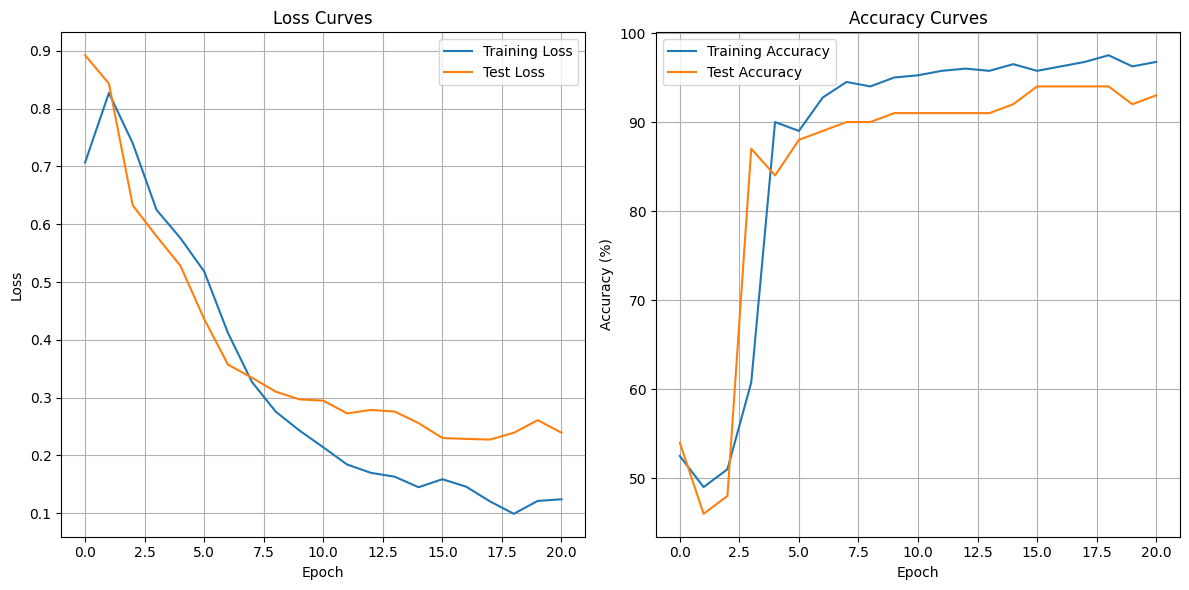

In [1263]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Plot the accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [1264]:
torch.save(model.state_dict(), "EmailModel_params12.pth")

In [26]:
def read_test_email(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    parts = text.split('"')  
    
    subject = parts[1].strip()
    body = parts[3].strip()
    
    new_email = {'Subject':subject, 'Body':body}
    return new_email

In [27]:
emails_total = []

for i in range(1,25):
    file_path = f"Data/random/rand{i}.txt"
    new_email = read_test_email(file_path)
    subject = new_email["Subject"]
    body = new_email["Body"]
    new_text = preprocess_text(f"{subject} {body}")
    emails_total.append(new_text)

len(emails_total)

24

In [28]:
tfidf_matrix = vectorizer.fit_transform(emails_total)
max_features = 30
test_email_padded = np.pad(tfidf_matrix.toarray(), ((0, 0), (0, max_features - tfidf_matrix.shape[1])), mode='constant')

test_email_tensor = torch.tensor(test_email_padded, dtype=torch.float32).to(device)
print(test_email_tensor)

# tfidf_matrix = vectorizer.fit_transform(emails_total)

# test_email_tensor = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float32).to(device)
# print(test_email_tensor)


tensor([[0.1907, 0.1100, 0.1819, 0.2107, 0.2002, 0.0000, 0.4214, 0.2107, 0.2107,
         0.1240, 0.1819, 0.2107, 0.2002, 0.2107, 0.1590, 0.2107, 0.0000, 0.1100,
         0.1737, 0.1907, 0.0000, 0.0000, 0.1661, 0.0000, 0.2107, 0.2107, 0.1819,
         0.2289, 0.0000, 0.2002],
        [0.1957, 0.2257, 0.1867, 0.2163, 0.2055, 0.0000, 0.2163, 0.2163, 0.2163,
         0.2546, 0.1867, 0.2163, 0.2055, 0.2163, 0.1632, 0.2163, 0.0000, 0.1129,
         0.1783, 0.1957, 0.0000, 0.0000, 0.1705, 0.0000, 0.2163, 0.2163, 0.1867,
         0.2349, 0.0000, 0.2055],
        [0.1907, 0.1100, 0.1819, 0.2107, 0.2002, 0.0000, 0.4214, 0.2107, 0.2107,
         0.1240, 0.1819, 0.2107, 0.2002, 0.2107, 0.1590, 0.2107, 0.0000, 0.1100,
         0.1737, 0.1907, 0.0000, 0.0000, 0.1661, 0.0000, 0.2107, 0.2107, 0.1819,
         0.2289, 0.0000, 0.2002],
        [0.2006, 0.2314, 0.1914, 0.2217, 0.2107, 0.0000, 0.2217, 0.2217, 0.2217,
         0.1305, 0.1914, 0.2217, 0.2107, 0.2217, 0.1673, 0.2217, 0.0000, 0.1157,
       

In [1273]:
loaded_model = EmailModel(test_email_tensor.shape[1]).to(device)
loaded_model.load_state_dict(torch.load("EmailModel_params10.pth"))

loaded_model.eval()
with torch.inference_mode():
    test_email_preds = loaded_model(test_email_tensor).squeeze().cpu().numpy()

rounded_preds = test_email_preds.round().astype(int)

print(rounded_preds[:10])
print(rounded_preds[10:])
# print(rounded_preds)

[1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 1 0 1 0 0 0 1 1 1]


In [29]:
loaded_model = EmailModel(test_email_tensor.shape[1]).to(device)
loaded_model.load_state_dict(torch.load("EmailModel_params10.pth"))
loaded_model.eval()

dummy_input = test_email_tensor




In [34]:
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

torch.onnx.export(loaded_model, dummy_input, "EmailModel.onnx",
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [35]:
!onnx-tf convert -i EmailModel.onnx -o email_model_tf

'onnx-tf' is not recognized as an internal or external command,
operable program or batch file.
